<a href="https://colab.research.google.com/github/Evrouin/Evrouin/blob/main/Hotdog_NotHotDog_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and GPU configuration

In [18]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pathlib

In [19]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

## Mount Google Drive

In [20]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/


## The Data

In [23]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [22]:
PATH = '/content/drive/MyDrive/hotdog-nothotdog'
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [24]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4242 files belonging to 2 classes.
Using 3394 files for training.


In [25]:
class_names = train_dataset.class_names

In [26]:
class_names

['hotdog', 'nothotdog']

In [27]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 4242 files belonging to 2 classes.
Using 848 files for validation.


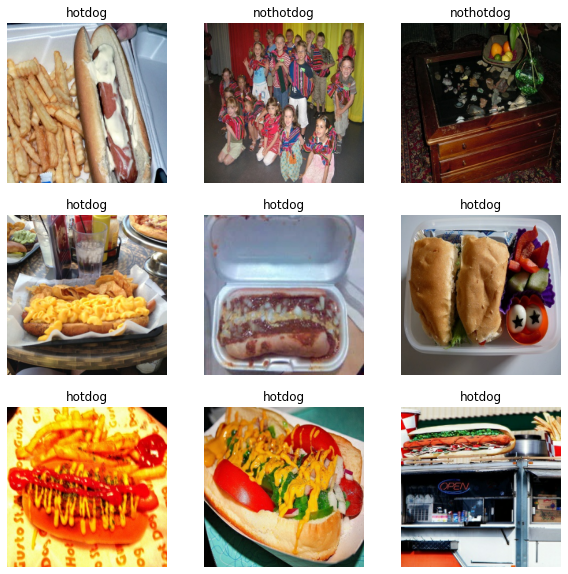

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [29]:
test_dataset = image_dataset_from_directory(test_dir,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             )

Found 400 files belonging to 2 classes.


In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Preprocessing

### Data Augmentation



In [31]:
data_augmentation = tf.keras.Sequential(
    [
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.3)
    ]
)

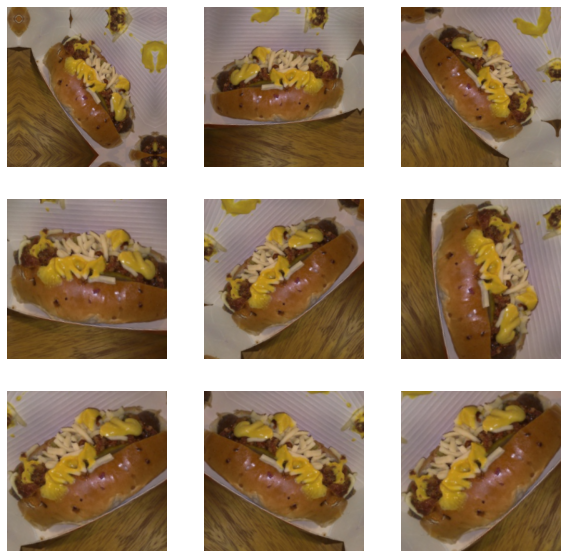

In [32]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Rescaling

In [33]:
rescale = preprocessing.Rescaling(1./255)

## Model Building

### Alexnet

In [34]:
# AlexNet variation implementation with Functional API in Tensorflow 2
def AlexNet():
    inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
    x = data_augmentation(inputs)
    x = rescale(x)
    x = layers.Conv2D(96, (11, 11), strides=4, activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Conv2D(256, (5, 5), strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs, name='AlexNet')
    return model

In [35]:
model_alexnet = AlexNet()

In [36]:
model_alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                           

In [37]:
model_alexnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0003),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [39]:
history_alexnet = model_alexnet.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10


107/107 [==============================] - 867s 8s/step - loss: 1.8993 - accuracy: 0.5144 - val_loss: 1.0943 - val_accuracy: 0.5153
Epoch 2/10
107/107 [==============================] - 32s 285ms/step - loss: 1.0181 - accuracy: 0.5295 - val_loss: 0.9275 - val_accuracy: 0.4693
Epoch 3/10
107/107 [==============================] - 31s 281ms/step - loss: 0.7492 - accuracy: 0.5813 - val_loss: 0.6825 - val_accuracy: 0.5401
Epoch 4/10
107/107 [==============================] - 31s 289ms/step - loss: 0.6802 - accuracy: 0.6276 - val_loss: 1.1469 - val_accuracy: 0.5071
Epoch 5/10
107/107 [==============================] - 31s 288ms/step - loss: 0.6682 - accuracy: 0.6252 - val_loss: 0.7972 - val_accuracy: 0.5731


In [40]:
def plotLearningCurve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

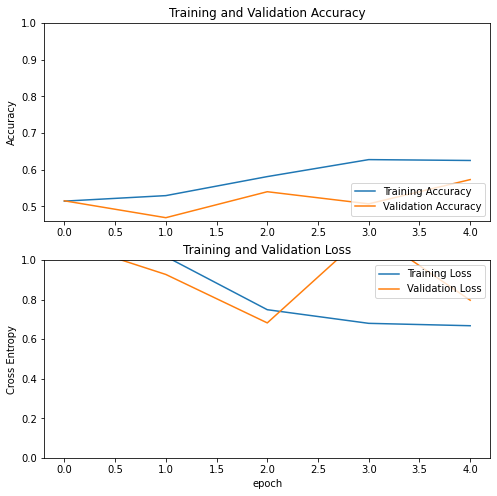

In [41]:
plotLearningCurve(history_alexnet)

In [42]:
model_alexnet.evaluate(test_dataset)

13/13 [==============================] - 137s 3s/step - loss: 0.6827 - accuracy: 0.5800


[0.682731032371521, 0.5799999833106995]

### Transfer learning with Pre-Trained VGG19

In [43]:
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

80134624/80134624 [==============================] - 5s 0us/step


In [44]:
base_model_vgg19.trainable = False

In [45]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.vgg19.preprocess_input(x)
x = base_model_vgg19(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_vgg19 = tf.keras.Model(inputs, outputs, name='vgg19')

In [46]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

In [47]:
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [49]:
history_vgg19 = model_vgg19.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=[callback])

Epoch 1/10


107/107 [==============================] - 58s 471ms/step - loss: 0.8964 - accuracy: 0.8232 - val_loss: 0.2573 - val_accuracy: 0.9175
Epoch 2/10
107/107 [==============================] - 48s 443ms/step - loss: 0.3460 - accuracy: 0.8671 - val_loss: 0.2630 - val_accuracy: 0.9068
Epoch 3/10
107/107 [==============================] - 49s 456ms/step - loss: 0.2620 - accuracy: 0.8951 - val_loss: 0.2387 - val_accuracy: 0.9186
Epoch 4/10
107/107 [==============================] - 48s 444ms/step - loss: 0.2328 - accuracy: 0.9031 - val_loss: 0.2173 - val_accuracy: 0.9269
Epoch 5/10
107/107 [==============================] - 49s 449ms/step - loss: 0.2217 - accuracy: 0.9113 - val_loss: 0.2062 - val_accuracy: 0.9304
Epoch 6/10
107/107 [==============================] - 48s 444ms/step - loss: 0.2095 - accuracy: 0.9128 - val_loss: 0.2801 - val_accuracy: 0.9080
Epoch 7/10
107/107 [==============================] - 49s 450ms/step - loss: 0.1970 - accuracy: 0.9140 - val_loss: 0.2450 - val_accuracy: 0.9

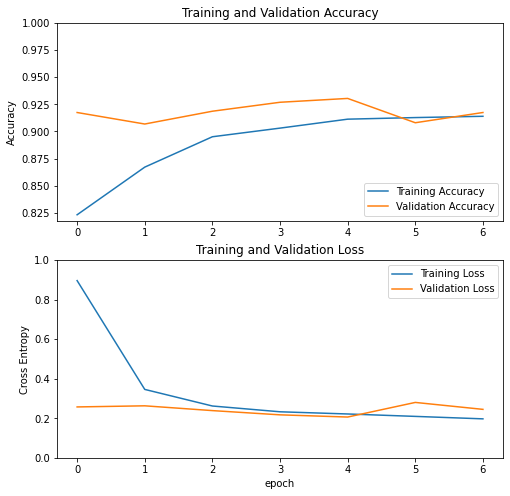

In [50]:
plotLearningCurve(history_vgg19)

In [51]:
model_vgg19.save('model_vgg19.h5')

In [52]:
model_vgg19.evaluate(test_dataset)

13/13 [==============================] - 3s 194ms/step - loss: 0.2575 - accuracy: 0.8900


[0.2575305700302124, 0.8899999856948853]

### Transfer learning with Pre-Trained ResNet50

In [53]:
base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

94765736/94765736 [==============================] - 7s 0us/step


In [54]:
base_model_resnet50.trainable = False

In [55]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model_resnet50(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_resnet50 = tf.keras.Model(inputs, outputs, name='resnet50')

In [56]:
model_resnet50.summary()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0  

In [57]:
model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [59]:
history_resnet50 = model_resnet50.fit(train_dataset,
                        epochs=10,
                        validation_data=validation_dataset,
                        callbacks=[callback])

Epoch 1/10


107/107 [==============================] - 50s 378ms/step - loss: 0.3369 - accuracy: 0.8630 - val_loss: 0.2540 - val_accuracy: 0.8927
Epoch 2/10
107/107 [==============================] - 39s 364ms/step - loss: 0.2467 - accuracy: 0.8922 - val_loss: 0.1485 - val_accuracy: 0.9387
Epoch 3/10
107/107 [==============================] - 39s 362ms/step - loss: 0.2285 - accuracy: 0.8989 - val_loss: 0.2025 - val_accuracy: 0.8939
Epoch 4/10
107/107 [==============================] - 39s 356ms/step - loss: 0.1994 - accuracy: 0.9125 - val_loss: 0.1304 - val_accuracy: 0.9505
Epoch 5/10
107/107 [==============================] - 38s 347ms/step - loss: 0.1754 - accuracy: 0.9249 - val_loss: 0.1843 - val_accuracy: 0.9233
Epoch 6/10
107/107 [==============================] - 39s 359ms/step - loss: 0.1868 - accuracy: 0.9225 - val_loss: 0.2443 - val_accuracy: 0.8880


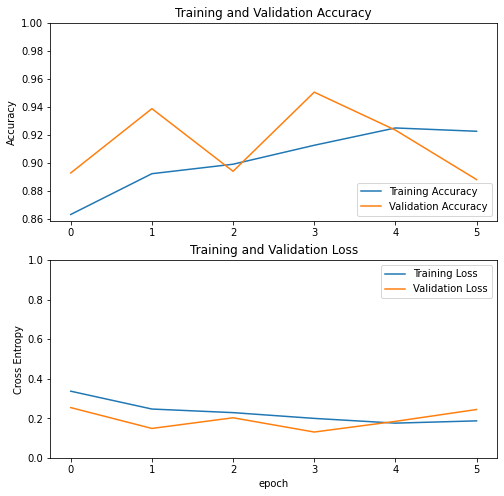

In [60]:
plotLearningCurve(history_resnet50)

In [61]:
model_resnet50.save('model_resnet50.h5')

In [62]:
model_resnet50.evaluate(test_dataset)

13/13 [==============================] - 3s 127ms/step - loss: 0.2069 - accuracy: 0.9100


[0.206851065158844, 0.9100000262260437]

### Transfer learning with Pre-Trained Inception V3

In [63]:
base_model_inception_v3 = tf.keras.applications.inception_v3.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

87910968/87910968 [==============================] - 5s 0us/step


In [64]:
base_model_inception_v3.trainable = False

In [65]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model_inception_v3(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_v3 = tf.keras.Model(inputs, outputs, name='inception_v3')

In [66]:
model_inception_v3.summary()

Model: "inception_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)            

In [67]:
model_inception_v3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [69]:
history_inception_v3 = model_inception_v3.fit(train_dataset,
                            epochs=10,
                            validation_data=validation_dataset,
                            callbacks=[callback])

Epoch 1/10


107/107 [==============================] - 48s 364ms/step - loss: 0.3330 - accuracy: 0.8704 - val_loss: 0.1830 - val_accuracy: 0.9245
Epoch 2/10
107/107 [==============================] - 35s 321ms/step - loss: 0.2658 - accuracy: 0.8907 - val_loss: 0.1884 - val_accuracy: 0.9210
Epoch 3/10
107/107 [==============================] - 33s 308ms/step - loss: 0.2483 - accuracy: 0.8960 - val_loss: 0.1938 - val_accuracy: 0.9127


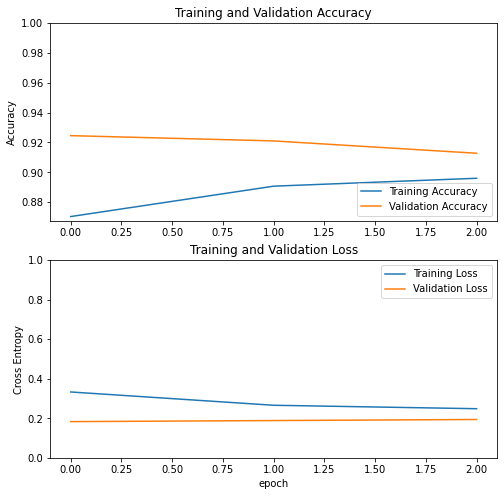

In [70]:
plotLearningCurve(history_inception_v3)

In [71]:
model_inception_v3.save('model_inception_v3.h5')

In [72]:
model_inception_v3.evaluate(test_dataset)

13/13 [==============================] - 2s 94ms/step - loss: 0.2329 - accuracy: 0.8925


[0.23290325701236725, 0.8924999833106995]

### Transfer learning with Pre-Trained Inception ResNet V2

In [73]:
base_model_inception_resnet_v2 = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = (256,256,3))

219055592/219055592 [==============================] - 12s 0us/step


In [74]:
base_model_inception_resnet_v2.trainable = False

In [75]:
inputs = tf.keras.Input(shape=(256, 256, 3), name='image')
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model_inception_resnet_v2(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(.3)(x)
outputs = layers.Dense(1)(x)
model_inception_resnet_v2 = tf.keras.Model(inputs, outputs, name='inception_resnet_v2')

In [76]:
model_inception_resnet_v2.summary()

Model: "inception_resnet_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                               

In [77]:
model_inception_resnet_v2.compile(optimizer=tf.keras.optimizers.Adam(),
                              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                              metrics=['accuracy'])

In [78]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [79]:
history_inception_resnet_v2 = model_inception_resnet_v2.fit(train_dataset,
                                    epochs=10,
                                    validation_data=validation_dataset,
                                    callbacks=[callback])

Epoch 1/10


107/107 [==============================] - 74s 542ms/step - loss: 0.3829 - accuracy: 0.8680 - val_loss: 0.1384 - val_accuracy: 0.9505
Epoch 2/10
107/107 [==============================] - 53s 490ms/step - loss: 0.2465 - accuracy: 0.9013 - val_loss: 0.1465 - val_accuracy: 0.9422
Epoch 3/10
107/107 [==============================] - 52s 482ms/step - loss: 0.2069 - accuracy: 0.9116 - val_loss: 0.1627 - val_accuracy: 0.9434


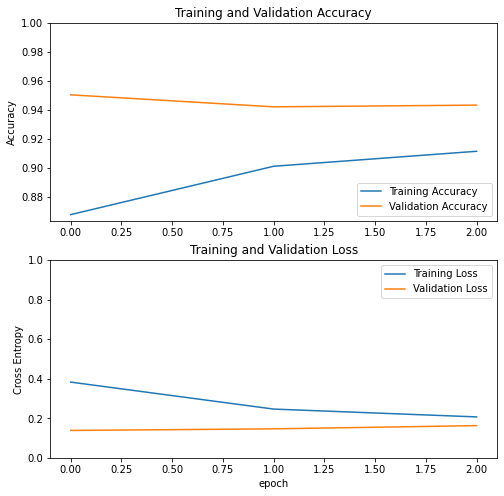

In [80]:
plotLearningCurve(history_inception_resnet_v2)

In [81]:
model_inception_resnet_v2.save('model_inception_resnet_v2.h5')

In [82]:
model_inception_resnet_v2.evaluate(test_dataset)

13/13 [==============================] - 4s 224ms/step - loss: 0.1535 - accuracy: 0.9400


[0.15350612998008728, 0.9399999976158142]

## Test Outputs

### Test Random Images from Dataset

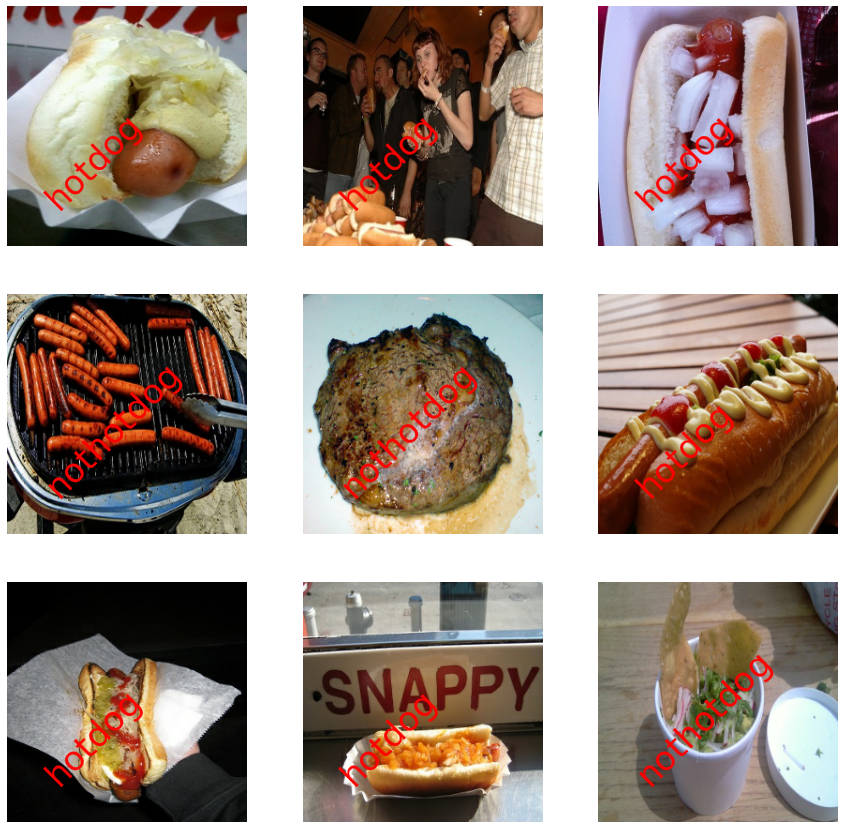

In [83]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_inception_resnet_v2.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions <= 0.5, 0, 1)

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label = class_names[predictions[i]]
    if label=='Hot Dog':
        plt.text(50, 200, label, rotation=45, color='lightgreen', fontsize=34, fontweight='bold')
    else:
        plt.text(35, 215, label, rotation=45, color='red', fontsize=34, fontweight='normal')
    plt.axis("off")